In [ ]:
import os
import cv2
import dlib
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import keras
import shutil
import time
import random
from scipy import stats
from sklearn.manifold import TSNE
from PIL import Image, ImageDraw
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.applications.efficientnet import EfficientNetB3
from keras.callbacks import Callback
from keras import regularizers
from keras.applications.densenet import preprocess_input as preprocess_input_densenet
from keras.applications.resnet import preprocess_input as preprocess_input_resnet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception

In [ ]:
# Đọc dữ liệu từ file CSV
autistic_data = pd.read_csv('/content/drive/MyDrive/Project_Python_DS/cleanData/Autistic.csv')
non_autistic_data = pd.read_csv('/content/drive/MyDrive/Project_Python_DS/cleanData/Non_Autistic.csv')
non_autistic_data = non_autistic_data.dropna()
autistic_data = autistic_data.dropna()

## **4. Xây dựng mô hình dự đoán**

### **4.1 Sử dụng dữ liệu được phai khá trên**

#### **4.1.1 Gộp dữ liệu và trích xuất các nhãn**

In [ ]:
autistic_data['label'] = 0
non_autistic_data['label'] = 1
# Gộp hai DataFrame thành một
merged_data = pd.concat([autistic_data, non_autistic_data], ignore_index=True)

# In ra một số dòng đầu của DataFrame mới
data = merged_data.dropna()
X = data[['Eyes_Distance', 'Upper_Face', 'Middle_Face', 'Mouth_Width', 'Philtrum_Length']]
y = data['label']

#### **4.1.1 Tách dữ liệu thành tập train, test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1120, 5)

In [ ]:
y_train.shape

(1120,)

#### **4.1.2 Huấn luyện mô hình**

Mô hình XGBoost có khả năng dự đoán cao và nhanh hơn gần 10 lần so với các kỹ thuật tăng cường độ dốc khác. Nó cũng bao gồm nhiều tham số chính quy hóa giúp giảm tình trạng quá khớp và cải thiện hiệu suất tổng thể. Do đó, nó còn được gọi là regularized boosting technique( kỹ thuật thường xuyên tăng cường)

In [ ]:
# Khởi tạo mô hình XGBoost Classifier
model = xgb.XGBClassifier(objective="multi:softmax", num_class=2, seed=42, 
                          n_estimators=200, learning_rate=0.1, max_depth=20, 
                          min_child_weight=1, subsample=1.0, colsample_bytree=1.0, 
                          gamma=0, reg_alpha=0, reg_lambda=0)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=2,
              num_parallel_tree=None, objective='multi:softmax', ...)

#### **4.1.3 Đánh giá mô hình**

In [ ]:
# Dự đoán trên tập huấn luyện và tập kiểm tra

y_test_pred = model.predict(X_test)

# Tính toán các thông số

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

results_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Test': [test_accuracy, test_precision, test_recall, test_f1_score]
}

results_df = pd.DataFrame(results_data)
results_df

,Metric,Test
0,Accuracy,0.814286
1,Precision,0.843750
2,Recall,0.771429
3,F1-Score,0.805970


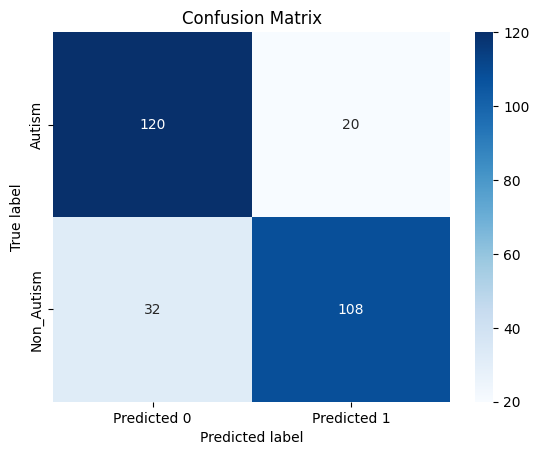

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Autism', 'Non_Autism'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Mô hình ổn định có độ chính xác (Accuracy) đạt khoảng 81.43% và thực hiện dự đoán trên đối tượng tự kỷ (Autistic) hiệu quả hơn dự đoán đối tượng không tự kỷ (Non-autistic).

#### **4.1.4 Thực hiện dự đoán**

Để đánh giá khách quan độ chính xác của mô hình xây dựng, ta thực hiện dự đoán trên mẫu được lấy trên mạng xã hội gần đây không nằm trong bộ dữ liệu ban đầu với một bức ảnh tự kỷ và không tự kỷ

In [ ]:
def predict_ML(image_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("D:\\Py for data science\\final project\\autism\\realtime\\shape_predictor_81_face_landmarks (1).dat")
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(image)
    features_dict = []
    for face in faces:
        # Tiền xử lý frame
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        cropped_face = image[y:y+h, x:x+w]

        image = cv2.resize(cropped_face, (224, 224))
        landmarks = predictor(gray, face)
            # Predict facial landmarks
        eye_distance = compute_distance(landmarks, 39, 42)
        upper_face_length = compute_distance(landmarks, 27, 71) 
        mid_face_height = compute_distance(landmarks, 33, 27) 
        mouth_width = compute_distance(landmarks, 51, 33) 
        philtrum_length = compute_distance(landmarks, 54, 48) 

        features_dict.append(eye_distance)
        features_dict.append(upper_face_length)
        features_dict.append(mid_face_height)
        features_dict.append(mouth_width)
        features_dict.append(philtrum_length)

        # Dự đoán
        prediction = model.predict_proba(np.array([features_dict]))

        # Lấy chỉ số của giá trị lớn nhất
        CLASS_NAMES = ["Autistic", "Non_Autistic"]
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])
        image.show()
        return {
            'class': predicted_class,
            'confidence': float(confidence)
        }

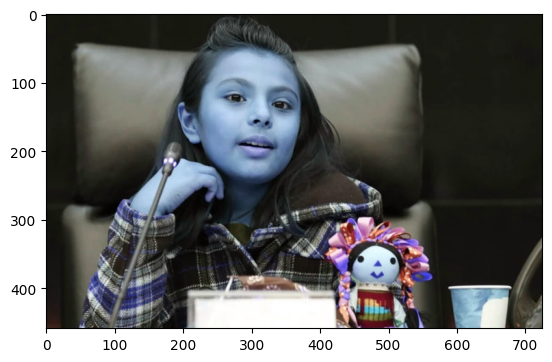

In [ ]:
image_path = 'Autism.jpg'
image = cv2.imread(image_path)
plt.imshow(image)

Result: Autistic (Confidence: 87.56%)


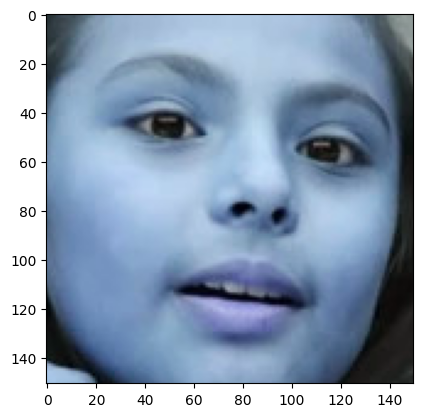

In [ ]:
image_path = 'Autism.jpg'
result = predict_ML(image_path)
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)

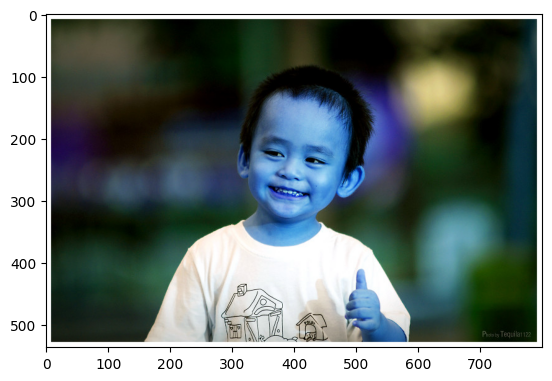

In [ ]:
image_path = 'Non_Autism.jpg'
image = cv2.imread(image_path)
plt.imshow(image)

Result: Non_Autistic (Confidence: 99.79%)


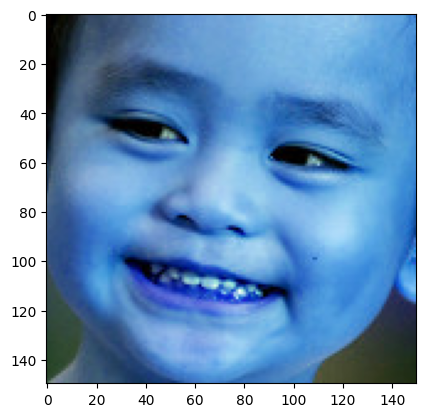

In [ ]:
image_path = 'Non_Autism.jpg'
result = predict_ML(image_path)
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)


### **4.2 Sử dụng dữ liệu hình ảnh**

#### **4.2.1 Tách tập dữ liệu thành train, test và valid**

In [ ]:
def split_data(input_folder, output_folder, train_ratio=0.86, test_ratio=0.07, val_ratio=0.):
    # Tạo các thư mục đích nếu chúng không tồn tại
    for folder in ['Autistic','Non_Autistic']:
        os.makedirs(os.path.join(output_folder, 'train', folder), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'test', folder), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'val', folder), exist_ok=True)

    # Lấy danh sách tất cả các tệp ảnh trong thư mục Autistic
    autistic_files = os.listdir(os.path.join(input_folder, 'Autistic'))
    autistic_images = [file for file in autistic_files if file.endswith(('.png', '.jpg'))]

    # Lấy danh sách tất cả các tệp ảnh trong thư mục Non_Autistic
    non_autistic_files = os.listdir(os.path.join(input_folder, 'Non_Autistic'))
    non_autistic_images = [file for file in non_autistic_files if file.endswith(('.png', '.jpg'))]

    # Hàm di chuyển ảnh vào các thư mục train, test, val
    def move_images(images, category_folder):
        num_train = int(len(images) * train_ratio)
        num_test = int(len(images) * test_ratio)
        num_val = int(len(images) * val_ratio)

        train_images = random.sample(images, num_train)
        remaining_images = list(set(images) - set(train_images))
        test_images = random.sample(remaining_images, num_test)
        val_images = list(set(remaining_images) - set(test_images))

        for img_name in train_images:
            source_path = os.path.join(input_folder, category_folder, img_name)
            dest_path = os.path.join(output_folder,  'train',category_folder, img_name)
            shutil.copy(source_path, dest_path)

        for img_name in test_images:
            source_path = os.path.join(input_folder, category_folder, img_name)
            dest_path = os.path.join(output_folder,  'test',category_folder, img_name)
            shutil.copy(source_path, dest_path)

        for img_name in val_images:
            source_path = os.path.join(input_folder, category_folder, img_name)
            dest_path = os.path.join(output_folder,  'val', category_folder,img_name)
            shutil.copy(source_path, dest_path)

    # Di chuyển ảnh cho thư mục Autistic
    move_images(autistic_images, 'Autistic')

    # Di chuyển ảnh cho thư mục Non_Autistic
    move_images(non_autistic_images, 'Non_Autistic')

In [ ]:
# Đường dẫn thư mục chứa hình ảnh gốc
input_folder = "/content/drive/MyDrive/Project_Python_DS/cleanData"

# Đường dẫn thư mục chứa kết quả
output_folder = "/content/drive/MyDrive/Project_Python_DS/DATA"

# Gọi hàm để tách dữ liệu
split_data(input_folder, output_folder)

#### **4.2.2 Xây dựng mô hình dự đoán**

**Xây dựng mô hình được đào tạo trước trên Imagenet.**

**ImageNet** là một cơ sở dữ liệu trực quan lớn được thiết kế để sử dụng trong nghiên cứu phần mềm nhận dạng đối tượng trực quan . Hơn 14 triệu hình ảnh đã được dự án chú thích bằng tay để cho biết những đối tượng nào được chụp trong hình và trong ít nhất một triệu hình ảnh, các hộp giới hạn cũng được cung cấp. ImageNet chứa hơn 20.000 danh mục, với một danh mục điển hình, chẳng hạn như "quả bóng bay" hoặc "dâu tây", bao gồm hàng trăm hình ảnh.

Các lớp cơ bản trong mạng tích chập (CNN).
1. Lớp Dense (Fully Connected): \
Chức Năng: Tất cả các nơ-ron trong lớp này được kết nối với tất cả các nơ-ron trong lớp trước đó và sau đó.
Sử Dụng: Được sử dụng để học mối quan hệ phức tạp trong dữ liệu.
2. Lớp Convolutional: \
Chức Năng: Thực hiện phép tích chập trên đầu vào, giúp trích xuất đặc trưng từ dữ liệu hình ảnh.
Sử Dụng: Thường được sử dụng trong xử lý hình ảnh và nhận dạng đối tượng.
3. Lớp Pooling: \
Chức Năng: Giảm kích thước của biểu diễn đặc trưng thông qua việc lấy giá trị tối đa hoặc trung bình từ các vùng không gian.
Sử Dụng: Giảm kích thước, giảm độ phức tạp tính toán.
4. Lớp Activation: \
Chức Năng: Thực hiện phép kích thích phi tuyến tính trên đầu ra của lớp trước đó.
Sử Dụng: Tạo tính phi tuyến tính, khả năng học mối quan hệ phức tạp.
5. Lớp Flatten: \
Chức Năng: Làm phẳng biểu diễn đặc trưng thành vectơ 1 chiều để truyền vào lớp Fully Connected.
Sử Dụng: Chuyển từ biểu diễn đặc trưng 2D (ví dụ: từ lớp Convolutional) thành đầu vào dạng vectơ cho lớp Fully Connected.
6. Lớp Dropout: \
Chức Năng: Ngẫu nhiên tắt một số nơ-ron trong quá trình huấn luyện để ngăn chặn quá mức học và overfitting.
Sử Dụng: Tăng tính tổng quát và ổn định của mô hình.
7. Lớp Batch Normalization: \
Chức Năng: Chuẩn hóa đầu vào của lớp để tăng tốc quá trình huấn luyện và giảm vấn đề covariate shift.
Sử Dụng: Tăng tốc và ổn định quá trình huấn luyện.

**4.2.2.1. Tiền xử lý dữ liệu đầu vào.**

In [ ]:
WEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
TRAIN_DIR = '/content/drive/MyDrive/Project_Python_DS/DATA/train'
TEST_DIR = '/content/drive/MyDrive/Project_Python_DS/DATA/test'
VAL_DIR = '/content/drive/MyDrive/Project_Python_DS/DATA/valid'
lr = 0.001
epoch=50

In [ ]:
def preprocess_data_input(MODEL_NAME, HEIGHT, WIDTH, BATCH_SIZE, TRAIN_DIR, TEST_DIR, VAL_DIR):
    preprocess_input_mapping = {
        "densenet": preprocess_input_densenet,
        "resnet": preprocess_input_resnet,
        "vgg16": preprocess_input_vgg16,
        "mobilenet": preprocess_input_mobilenet,
        "efficientnet": preprocess_input_efficientnet,
        "inception": preprocess_input_inception
    }
    train_datagen =  ImageDataGenerator(
      preprocessing_function = preprocess_input_mapping[MODEL_NAME],
      rotation_range = 90,
      horizontal_flip = True,
      vertical_flip = True,
    )
    train_generator= train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE, color_mode='rgb',class_mode='categorical', shuffle=True)
    test_generator = train_datagen.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE, color_mode='rgb',class_mode='categorical', shuffle=False)
    val_generator= train_datagen.flow_from_directory(VAL_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE, color_mode='rgb',class_mode='categorical', shuffle=False)
    return train_generator, test_generator, val_generator

#### **4.2.2.2. Xây dựng hàm callback**

In [ ]:
class LRA(Callback):
    
    def __init__(self, model, test_generator, csv_filename, epochs = 50, patience=2, threshold=.95, factor=.5):
        super(LRA, self).__init__()
        self.model = model
        self.patience=patience 
        self.threshold=threshold 
        self.factor=factor
        self.lr=float(keras.backend.get_value(self.model.optimizer.lr)) 
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.count=0
        self.test_generator = test_generator
        self.train_history = {'Epoch': [], 'Train Loss': [], 'Train Accuracy': []}
        self.val_history = {'Epoch': [], 'Validation Loss': [], 'Validation Accuracy': []}

        self.csv_filename = csv_filename
        self.num_epochs = 0
        self.epochs = epochs 
        msg='Starting Training - Initializing Custom Callback'
        print(msg)

    def check_and_export_csv(self):
        if self.num_epochs == self.epochs:
            self.export_history_to_csv()


    def write_val_history(self, epoch, val_loss, val_accuracy):
        self.val_history['Epoch'].append(epoch)
        self.val_history['Validation Loss'].append(val_loss)
        self.val_history['Validation Accuracy'].append(val_accuracy)

    def write_train_history(self, epoch, train_loss, train_accuracy):
        self.train_history['Epoch'].append(epoch)
        self.train_history['Train Loss'].append(train_loss)
        self.train_history['Train Accuracy'].append(train_accuracy)

    def export_history_to_csv(self):
        train_df = pd.DataFrame(self.train_history)
        val_df = pd.DataFrame(self.val_history)
        test_df = pd.DataFrame(self.test_metrics)

    
        result_df = pd.merge(train_df, val_df, on='Epoch')
        result_df = pd.merge(result_df, test_df, on='Epoch')

   
        result_df.to_csv(self.csv_filename, index=False)


    def on_epoch_end(self, epoch, logs=None):  
        lr=float(keras.backend.get_value(self.model.optimizer.lr))
        v_loss=logs.get('val_loss') 
        acc=logs.get('accuracy') 
        if acc < self.threshold: 
            if acc>self.highest_tracc: 
                msg= f'\ntraining accuracy improved from  {self.highest_tracc:7.2f} to {acc:7.2f} learning rate held at {lr:9.6f}'
              
                self.highest_tracc=acc 
                self.model.best_weights = self.model.get_weights() 
                count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
            else: 
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor 
                    keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    self.count=0 
                    if v_loss<self.lowest_vloss:
                        self.lowest_vloss=v_loss
                    msg=f'\nfor epoch {epoch +1} training accuracy did not improve for {self.patience } consecutive epochs, learning rate adjusted to {lr:9.6f}'
                    print(msg)
                else:
                    self.count=self.count +1
                    msg=f'\nfor  epoch {epoch +1} training accuracy did not improve, patience count incremented to {self.count}'
                    print(msg)
        else: 
            if v_loss< self.lowest_vloss: 
                msg=f'\nfor epoch {epoch+1} validation loss improved from  {self.lowest_vloss:7.4f} to {v_loss:7.4}, saving best weights'
                print(msg)
                self.lowest_vloss=v_loss 
                self.model.best_weights = self.model.get_weights() 
                self.count=0 
            else:
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor
                    msg=f'\nfor epoch {epoch+1} validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:9.6f}'
                    self.count=0 
                    print(msg)
                    keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                else:
                    self.count =self.count +1
                    msg=f'\nfor epoch {epoch+1} validation loss did not improve patience count incremented to {self.count}'
                    print(msg)

        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        train_loss = logs.get('loss')
        train_accuracy = logs.get('accuracy')

        self.write_train_history(epoch + 1, train_loss, train_accuracy)
        self.write_val_history(epoch + 1, val_loss, val_accuracy)

        self.num_epochs += 1
        self.check_and_export_csv()


Thực hiện huấn luyện tùy chỉnh lần lượt các mô hình là InpectionV3, Mobilenet, DenseNet201, EfficientNetB3. Ta được kết quả và thực hiện so sánh model.

In [ ]:
history_densNet = pd.read_csv('densNet201_50.csv')
history_efficientNet = pd.read_csv('efficientNetB3_300_300_50.csv')
history_inception = pd.read_csv('inception_50.csv')
history_mobilenet = pd.read_csv('mobilenet_50.csv')
model_densNet = load_model('densNet201_50.h5')
model_efficientNet = load_model('efficientNetB3_300_300_50.h5')
model_inception = load_model('inception_50.h5')
model_mobilenet = load_model('mobilenet_50.h5')

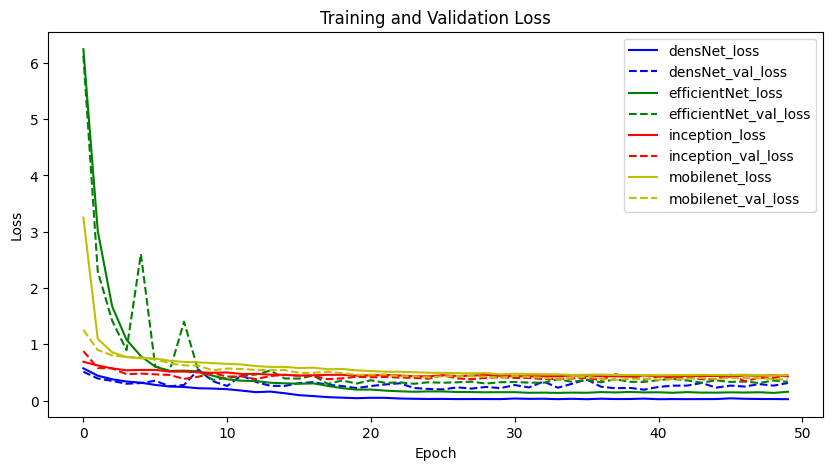

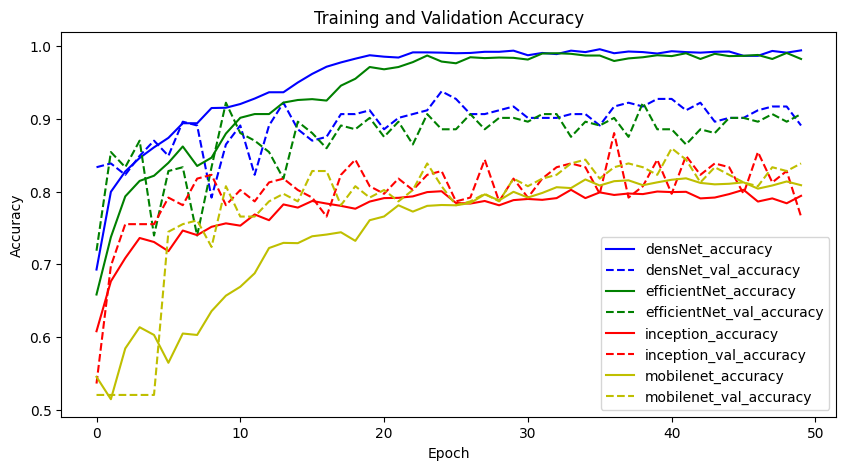

In [ ]:
dfs = [history_densNet, history_efficientNet, history_inception, history_mobilenet]
CNN_name = ['densNet', 'efficientNet', 'inception', 'mobilenet']
colors = ['b', 'g', 'r', 'y']
# Biểu đồ thứ nhất (loss và val_loss)
plt.figure(figsize=(10, 5))
for i, (df, color) in enumerate(zip(dfs, colors)):
    plt.plot(df.index, df['Train Loss'], color=color, linestyle='-', label=f'{CNN_name[i]}_loss')
    plt.plot(df.index, df['Validation Loss'], color=color, linestyle='--', label=f'{CNN_name[i]}_val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Biểu đồ thứ hai (accuracy và val_accuracy)
plt.figure(figsize=(10, 5))
for i, (df, color) in enumerate(zip(dfs, colors)):
    plt.plot(df.index, df['Train Accuracy'],  color=color, linestyle='-', label=f'{CNN_name[i]}_accuracy')
    plt.plot(df.index, df['Validation Accuracy'],  color=color, linestyle='--', label=f'{CNN_name[i]}_val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def preprocess_data_input(MODEL_NAME, HEIGHT, WIDTH, BATCH_SIZE, VAL_DIR):
    preprocess_input_mapping = {
        "densNet": preprocess_input_densenet,
        "rensNet": preprocess_input_resnet,
        "inception": preprocess_input_inception,
        "mobilenet": preprocess_input_mobilenet,
        "efficientNet": preprocess_input_efficientnet,
    }
    train_datagen =  ImageDataGenerator(
      preprocessing_function = preprocess_input_mapping[MODEL_NAME],
    )
    val_generator= train_datagen.flow_from_directory(VAL_DIR,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE, color_mode='rgb',class_mode='categorical', shuffle=False)
    return val_generator

CNN_name = ['densNet', 'efficientNet', 'inception', 'mobilenet']

test_generator=[]
for i in CNN_name:
    test_generator.append(preprocess_data_input(i, 224, 224, 32, 'D:\\Py for data science\\final project\\autism\\archive\\AutismDataset\\test_fake'))


historys = {
    'densNet': history_densNet,
    'efficientNet': history_efficientNet,
    'inception': history_inception,
    'mobilenet': history_mobilenet,
}
models = {
    'densNet': model_densNet,
    'efficientNet': model_efficientNet,
    'inception': model_inception,
    'mobilenet': model_mobilenet,
}
# Định nghĩa các mô hình và lưu kết quả vào DataFrame
results = pd.DataFrame(columns=['Model', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Duyệt qua từng mô hình
for i, (model_name, history_name) in enumerate(zip(models, historys)):
    # Thực hiện dự đoán của mô hình và tính toán các giá trị đánh giá
    y_pred = models[model_name].predict(test_generator[i])  # Thay thế bằng hàm dự đoán thực tế của bạn
    y_pred_binary = np.argmax(y_pred, axis=1)
    y_true = test_generator[i].classes
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)

    # Lấy thông tin cuối cùng của quá trình huấn luyện từ DataFrame
    last_row = historys[history_name].iloc[-1]

    # Lưu kết quả vào DataFrame
    results = results.append({
        'Model': model_name,
        'Train Loss': last_row['Train Loss'],
        'Train Accuracy': last_row['Train Accuracy'],
        'Validation Loss': last_row['Validation Loss'],
        'Validation Accuracy': last_row['Validation Accuracy'],

        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, ignore_index=True)



Found 200 images belonging to 2 classes.


Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
7/7 [==============================] - 2s 278ms/step


In [ ]:
results

,Model,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy,Accuracy,Precision,Recall,F1-Score
0,densNet,0.023932,0.993701,0.311509,0.890625,0.890,0.872340,0.83,0.850644
1,efficientNet,0.155883,0.981890,0.330969,0.906250,0.905,0.909091,0.90,0.904523
2,inception,0.428707,0.794095,0.456216,0.765625,0.760,0.770833,0.74,0.755102
3,mobilenet,0.451443,0.808661,0.370980,0.838542,0.755,0.752475,0.76,0.756219


#### **4.2.2.3. Mô hình tinh chỉnh efficientNetB3**


Sử dụng mô hình EfficientNetB3 với các tham số tùy chỉnh nhất định để đáp ứng nhu cầu của vấn đề phân loại hình ảnh.  \
Mô hình được khởi tạo với trọng số đào tạo trước trên ImageNet và được cấu hình để đào tạo lại (trainable=True).  \
Đối với kiến trúc, em đã thêm một fully connected layer với 256 đơn vị, sử dụng hàm kích hoạt ReLU để tăng khả năng học của mô hình, em đã áp dụng regularizer L2 với hệ số là 0.016 cho trọng số của kernel, nhằm kiểm soát giá trị của chúng và ngăn chặn hiện tượng overfitting. Đồng thời, em đã sử dụng regularizer L1 với hệ số là 0.006 trên cả giá trị kích hoạt của layer và trọng số bias...   \
Để ổn định quá trình huấn luyện, em thêm một lớp Dropout với tỷ lệ 0.4 để giảm overfitting.  \
Cuối cùng, output layer được thiết lập với 2 đơn vị và hàm kích hoạt softmax để phù hợp với vấn đề phân loại hai lớp. Em đặt mô hình có thể đào tạo lại để tối ưu hóa hiệu suất trên dữ liệu tùy chỉnh.

In [ ]:
def efficientNetB3():
    base_model = keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224, 224, 3), pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(2, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    return model

In [ ]:
efficientNet = efficientNetB3()

In [ ]:
efficientNetB3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [ ]:
adam = Adam(learning_rate=0.001)
efficientNet.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_generator, test_generator, val_generator = preprocess_data_input('efficientnet', HEIGHT, WIDTH, BATCH_SIZE, TRAIN_DIR, TEST_DIR, VAL_DIR)
print(train_generator.class_indices)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
{'autistic': 0, 'non_autistic': 1}


In [ ]:
results = efficientNet.fit(x=train_generator, epochs=epoch,
                      workers=8, validation_data=val_generator,
                      validation_steps=val_generator.samples//BATCH_SIZE,
                      shuffle=True, callbacks=[LRA(model = efficientNet, test_generator = test_generator, csv_filename = "efficientNetB3_50.csv")])

Starting Training - Initializing Custom Callback
Epoch 1/50
80/80 [==============================] - 188s 1s/step - loss: 6.2941 - accuracy: 0.6634 - val_loss: 6.1601 - val_accuracy: 0.6719
Epoch 2/50
80/80 [==============================] - 107s 1s/step - loss: 2.9808 - accuracy: 0.7488 - val_loss: 2.3555 - val_accuracy: 0.8073
Epoch 3/50
80/80 [==============================] - 98s 1s/step - loss: 1.7173 - accuracy: 0.7882 - val_loss: 1.2518 - val_accuracy: 0.8281
Epoch 4/50
80/80 [==============================] - 108s 1s/step - loss: 1.0878 - accuracy: 0.8213 - val_loss: 1.1975 - val_accuracy: 0.7865
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.8154
for  epoch 5 training accuracy did not improve, patience count incremented to 1
80/80 [==============================] - 105s 1s/step - loss: 0.8748 - accuracy: 0.8154 - val_loss: 1.1448 - val_accuracy: 0.8281
Epoch 6/50
80/80 [==============================] - ETA: 0s - loss: 0.8431 - accurac

In [ ]:
test_loss, test_accuracy = efficientNet.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 11s 1s/step - loss: 0.3432 - accuracy: 0.9100
Test Loss: 0.3432, Test Accuracy: 0.9100


Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       100
           1       0.91      0.90      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



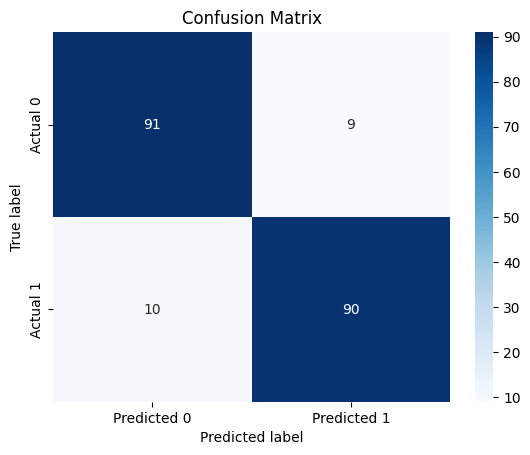

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Dự đoán trên tập kiểm thử
y_pred = efficientNet.predict_generator(test_generator)

# Nhãn thực tế của tập kiểm thử
y_true = test_generator.classes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Chuyển đổi xác suất thành nhãn dự đoán (0 hoặc 1)
y_pred_binary = np.argmax(y_pred, axis=1)
# Đánh giá accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# In classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_binary))

import seaborn as sns
cm = confusion_matrix(y_true, y_pred_binary)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Với mô hình CNN và XGB đã xây dựng nhận thấy rằng độ chính xác của mô hình CNN cao và ổn định hơn là vì CNN có khả năng tự động học các đặc trưng phức tạp của ảnh dựa vào mô hình hóa mối quan hệ đa chiều giữa các điểm trên khuôn mặt, các đặc trưng nổi bật, và sự biến đổi không tuyến tính trong dữ liệu hình ảnh sẽ đầy đủ và tốt hơn chỉ một vài đặc trưng được sử dụng cho mô hình XGB.

In [ ]:
efficientNet.save('densNet201_50.h5')

#### **4.2.3 Thực hiện dự đoán**

In [ ]:
def predict_DL(image_path):
 
    image = cv2.imread(image_path)
    faces = detector(image)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        cropped_face = image[y:y+h, x:x+w]

        resized_frame = cv2.resize(cropped_face, (300, 300))
        img = keras.applications.efficientnet.preprocess_input(resized_frame)
        img = np.expand_dims(img, axis=0)


        prediction = efficientNet.predict(img)

        CLASS_NAMES = ["Autistic", "Non_Autistic"]
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])

        return {
            'class': predicted_class,
            'confidence': float(confidence)
        }

In [ ]:
result = predict_DL('Autism.jpg')
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)

1/1 [==============================] - 0s 89ms/step
Result: Autistic (Confidence: 95.31%)


In [ ]:
result = predict_DL('Non_Autism.jpg')
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)

1/1 [==============================] - 0s 75ms/step
Result: Non_Autistic (Confidence: 99.33%)
